In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
%matplotlib inline

# read the whole experiment results
#df = pd.read_csv("./results/results_method1_v2_error_rate_add_noise_model-211022.csv")
df = pd.read_csv("./results/results_new_xy_5.csv")

In [27]:
df.head()

,noisy_rate,error_rate,dataset,noise_type,causal,inital_noise,seed
0,0.1,0.49960,xyguassian,instance,1,0.01,1
1,0.2,0.50110,xyguassian,instance,1,0.01,1
2,0.3,0.50535,xyguassian,instance,1,0.01,1
3,0.4,0.50640,xyguassian,instance,1,0.01,1
4,0.5,0.49975,xyguassian,instance,1,0.01,1


p1:  3.946557119950334e-15
p2:  4.4442227675745016e-13
slope:  -0.003729786133333354


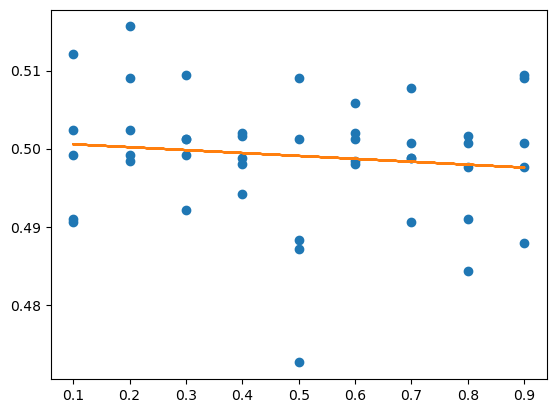

In [35]:

df_krkp=df[(df['dataset'] == 'krkp') & (df['noise_type']=='sym') & (df['initial_noise']==0.2 )]

slope, intercept, r, p, std =st.linregress(df_krkp['noise_rate'],df_krkp['error_rate'])

t1 = (slope - 0.05) / std
# single side t-test for t1
p1 = st.t.cdf(t1, df_krkp.shape[0] - 2)

t2 = (slope - -0.05)/ std
# single side t-test for t2
p2 = 1-st.t.cdf(t2, df_krkp.shape[0] - 2)

print("p1: ", p1)
print("p2: ", p2)
print("slope: ", slope)

plt.plot(df_krkp['noise_rate'],df_krkp['error_rate'],'o')
plt.plot(df_krkp['noise_rate'],slope*df_krkp['noise_rate']+intercept,'-')
# plt.text(0.1,0.52,'slope='+str(slope)+'\nintercept='+str(intercept)+'\nr='+str(r)+'\np='+str(p)+' std='+str(std))

In [28]:
# group by to calculate mean and std of error rate
df2=df.groupby(["dataset","noise_type","inital_noise","noisy_rate"]).agg([np.mean, np.std])
df2=df2['error_rate']
df2

mean       std
dataset    noise_type inital_noise noisy_rate                   
xyguassian instance   0.01         0.1         0.49992  0.001240
                                   0.2         0.49940  0.002549
                                   0.3         0.50143  0.002591
                                   0.4         0.50085  0.004603
                                   0.5         0.49810  0.003968
...                                                ...       ...
           sym        0.60         0.5         0.49756  0.004836
                                   0.6         0.50002  0.002367
                                   0.7         0.50048  0.003363
                                   0.8         0.49963  0.003887
                                   0.9         0.50135  0.004358

[108 rows x 2 columns]

In [29]:
# save csv file according to dataset
#dataset_names = ["xyguassian", "yxguassian", "balancescale", "krkp", "waveform", "splice", "cifar10", "cifar10n_worst", "cifar10n_aggre", "cifar10n_random1", "cifar10n_random2", "cifar10n_random3"]
dataset_names = ['xyguassian', 'yxguassian']#, 'balancescale', 'krkp', 'waveform', 'splice']
for name in dataset_names:
    path = './results/csv/'+name +'_groupby2.csv'
    df_temp = df[df['dataset']==name]
    df_temp = df_temp.groupby(["noise_type","inital_noise","noisy_rate"]).agg([np.mean, np.std])
    df_temp = df_temp['error_rate']
    print(path)
    df_temp.to_csv(path)


./results/csv/xyguassian_groupby2.csv
./results/csv/yxguassian_groupby2.csv


/var/folders/z8/zm1gct552gb8700n_kq3pm9h0000gn/T/ipykernel_65525/988332667.py:7: FutureWarning: ['dataset'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_temp = df_temp.groupby(["noise_type","inital_noise","noisy_rate"]).agg([np.mean, np.std])


3.6693159621847826e-10



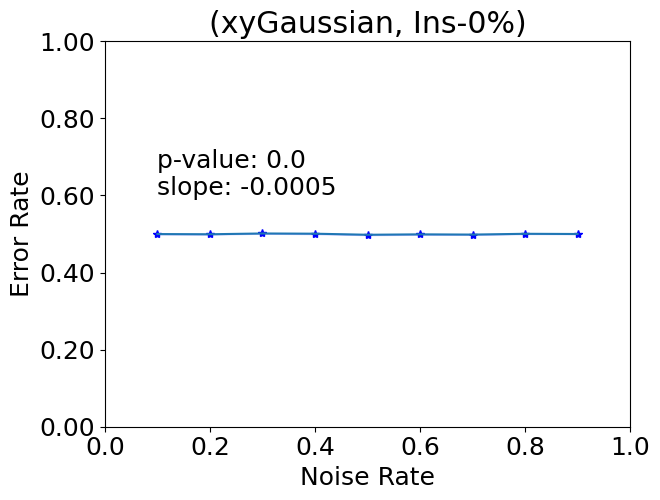

4.6436732792365376e-08



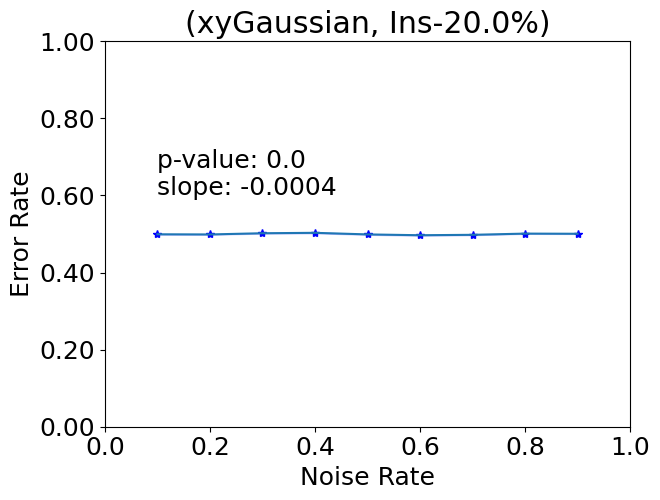

1.5401894093436397e-08



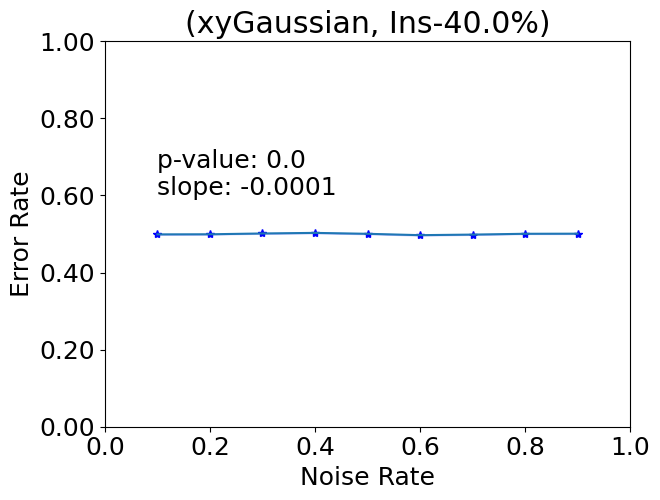

2.4118884702070845e-10



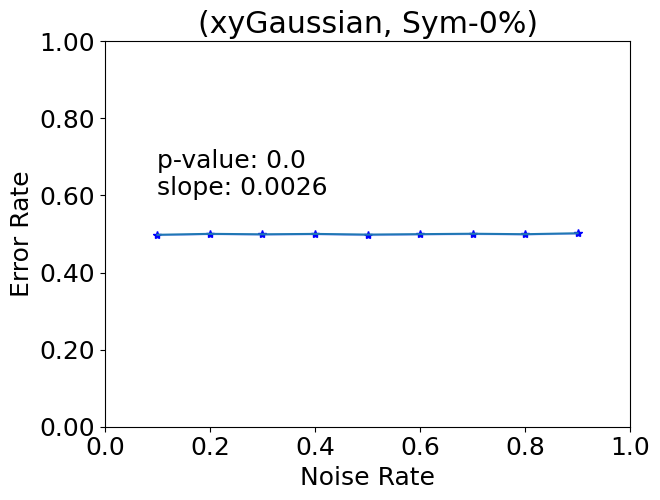

2.1090591089786624e-12



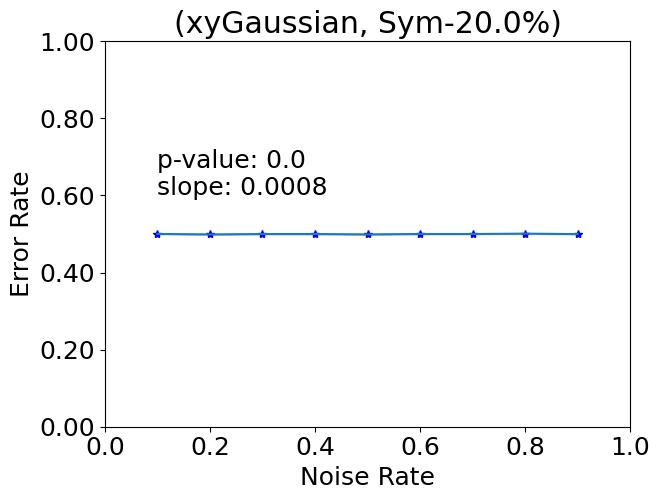

2.242628344541745e-10



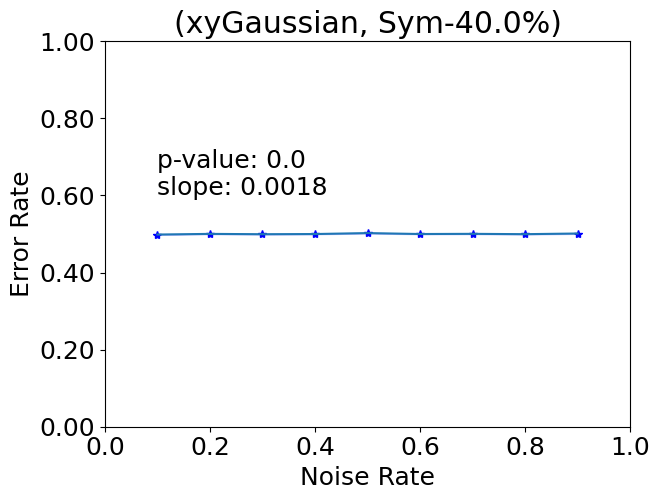

2.4118884702070845e-10



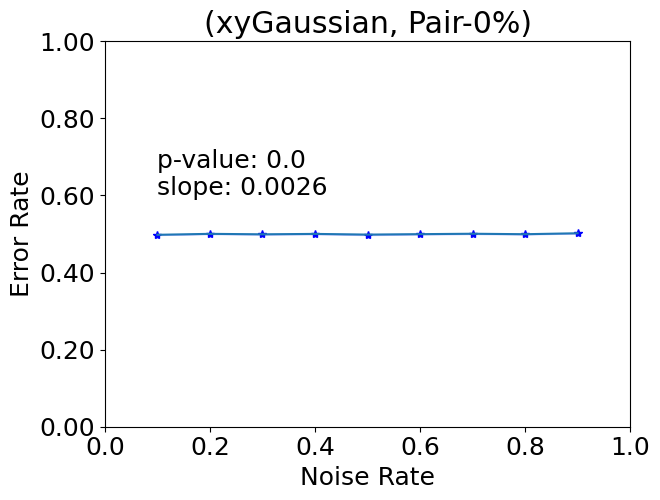

2.1090591089786624e-12



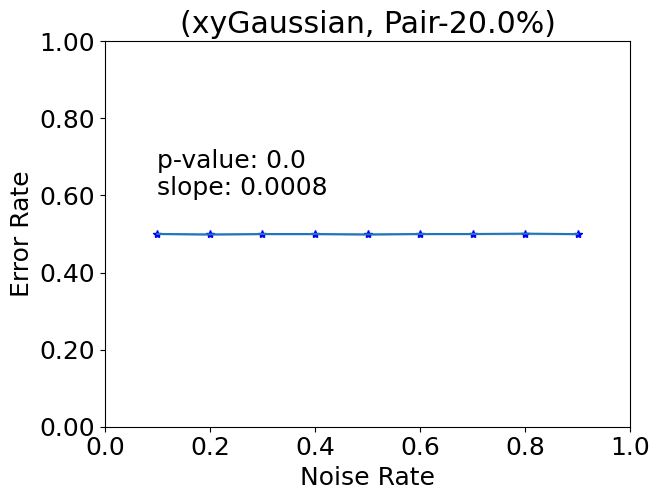

2.242628344541745e-10



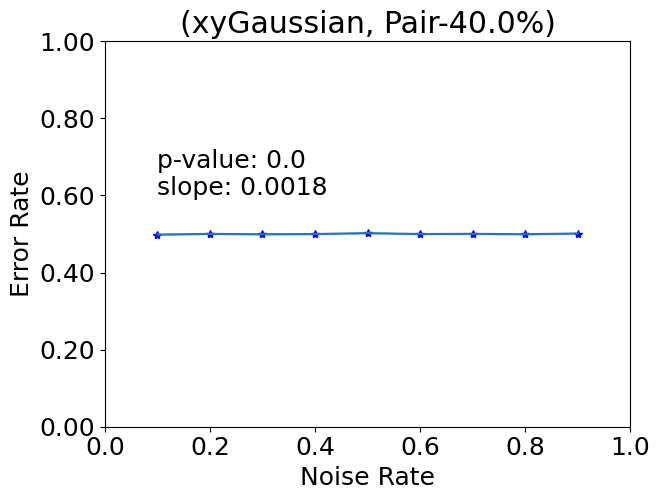

In [7]:
from asyncio import threads
from operator import contains
import scipy.stats as st

from matplotlib.ticker import FormatStrFormatter


corr_table = pd.DataFrame(columns=['dataset','noise_type','initial_noise','corr'])

dataset_names = ["xyguassian"]# "yxguassian", "balancescale", "krkp", "waveform", "splice", "cifar10", "cifar10n_worst", "cifar10n_aggre", "cifar10n_random1", "cifar10n_random2", "cifar10n_random3"]



def generate_plot_individual(dataset_name, df, corr_table, threshold=0.05):
    
    name_dict ={'yxguassian':'yxGaussian','xyguassian':'xyGaussian','balancescale':'BalanceScale','krkp':'KRKP','waveform':'Waveform','splice':'Splice','cifar10':'CIFAR10','cifar10n_worst':'CIFAR10N_worst','cifar10n_aggre':'CIFAR10N_aggre','cifar10n_random1':'CIFAR10N_random1','cifar10n_random2':'CIFAR10N_random2','cifar10n_random3':'CIFAR10N_random3'}

    noise_dict = {'sym':'Sym','pair':'Pair','instance':'Ins'}


    noise_type_list = ["instance","sym","pair"]
    initial_noise_list = [0.01, 0.2, 0.4]

    for noise_type in noise_type_list:
        for initial_noise in initial_noise_list:
    
            df_temp = df[(df['noise_type']==noise_type) & (df['inital_noise']==initial_noise)]
            x=df_temp['noisy_rate']
            y =df_temp['mean']
            
            y_std = df_temp['std']

            # Define the confidence interval
            ci = 0.1 * y_std / y
            # calculate correlation coefficient
            corr = np.corrcoef(x, y)[0, 1]
            # regression
            slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
            
            # upper bound of slope at 95% confidence interval
            slope_upper = slope + 1.96 * std_err
            # lower bound of slope at 95% confidence interval
            slope_lower = slope - 1.96 * std_err

            # t-test for slope
            alpha = 0.05

            # one-tail t-test for slope left side test:

            # H0: slope >= 0.05
            # H1: slope < 0.05
            t1 = (slope - 0.05) / std_err
            # single side t-test for t1
            
            p1 = st.t.cdf(t1, df_temp.shape[0] - 1)


            # one-tail t-test for slope right side test
            
            # H0: slope <= -0.05
            # H1: slope > -0.05
            t2 = (slope - -0.05)/ std_err
            # single side t-test for t2
            p2 = 1-st.t.cdf(t2, df_temp.shape[0] - 1)
            maxp = max(p1, p2)
            #print("alpha/2:", alpha/2.0)
            print(maxp)
            # if max(p1,p2) < alpha/2.0 :
            #     output = "reject H0, slope <0.05 and >-0.05"                
            # else:
            #     output="cannot reject H0"
            output = ""
            print(output)

            plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

            y_pred = slope * x + intercept

            # Plot the sinus function
            # plot scatter

            


            
            #plt.plot(x, y_pred,'--', 'r', label='fitted line')
            
            plt.plot(x, y,'*', color='blue')
            plt.plot(x,y,'-')
            #plt.scatter(x, y, label=noise_type)     
            #plt.plot(x,y)
            plt.ylim(0,1)
            # round y axis to 2 decimal places
            
            # print the slope with 2 decimal places

            #print(f"slope: {slope:.2f}")
            # s = f"slope: {slope:.4f}"
            # if slope_upper>threshold or slope_lower<-threshold:
            #     output = s+"\nthe 95% CI of slope is out of the range ["+str(-threshold) +","+str(threshold)+"]"
            # else:
            #     output = s+"\nthe 95% CI  of slope is within the range ["+str(-threshold)+","+str(threshold)+"]"

            
                        
            #print('r-squared: '+str(round(r_value**2,4))+'\np-value: '+str(round(p_value,6))+'\nslope: '+str(round(slope,4)))
            #plt.text(0.1, 0.5, 'r-squared: '+str(round(r_value**2,4))+'\np-value: '+str(round(p_value,6))+'\nslope: '+str(round(slope,4)), fontsize=12)
           
            #plt.axis.set_major_formatter(FormatStrFormatter('%g'))
            plt.rcParams.update({'font.size': 18})
            plt.xlabel('Noise Rate')
            plt.ylabel('Error Rate')
            plt.xlim(0,1)

            if initial_noise == 0.01:
                initial_noise = 0

            plt.title("(" +name_dict[dataset_name]+", "+noise_dict[noise_type]+"-"+ str(initial_noise*100) +"%)"+output)
            
            # Plot the confidence interval
            plt.text(0.1, 0.6, '\np-value: '+str((maxp,4))+'\nslope: '+str(round(slope,4)), fontsize=18)
            plt.fill_between(x, (y-ci), (y+ci), color='blue', alpha=0.2)
            plt.tight_layout(pad=0, w_pad=0, h_pad=0)
            plt.savefig('./results/pdf/'+dataset_name+'_'+noise_type+'_'+str(initial_noise)+'.pdf')
            # increase font size of title and axis
            

            plt.show()
            #df_corr_temp= pd.DataFrame([[dataset_name, noise_type, initial_noise, corr]], columns=['dataset','noise_type','initial_noise','corr'])
            corr_table.loc[len(corr_table)] = [dataset_name, noise_type, initial_noise, corr]
            plt.close()

for name in dataset_names:

    if (contains(name, 'cifar10n')==False):
        
        df = pd.read_csv("./results/csv/"+name +'_groupby2.csv')
        generate_plot_individual(name, df, corr_table,threshold=0.1)


In [295]:
corr_table

,dataset,noise_type,initial_noise,corr
0,xygaussian,instance,0.1,0.992054
1,xygaussian,instance,0.2,0.987290
2,xygaussian,instance,0.3,0.975612
3,xygaussian,sym,0.1,0.994853
4,xygaussian,sym,0.2,0.944291
...,...,...,...,...
103,cifar10n_random3,sym,0.2,0.999996
104,cifar10n_random3,sym,0.3,0.999996
105,cifar10n_random3,pair,0.1,0.999996
106,cifar10n_random3,pair,0.2,0.999996


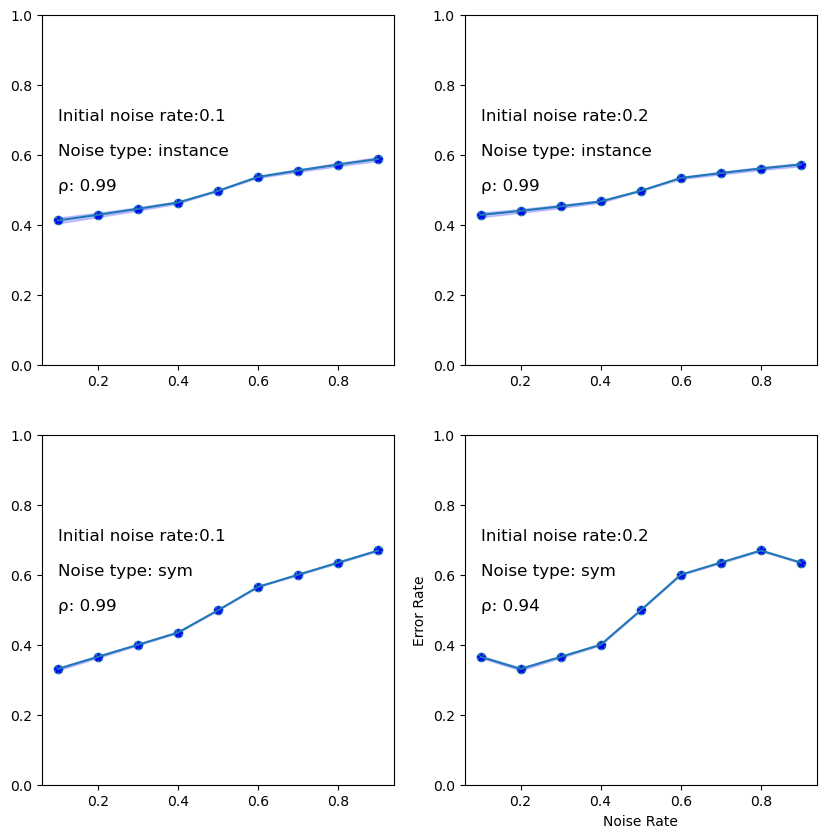

In [232]:
noise_type_list = ["instance","sym"]
initial_noise_list = [0.1,0.2]
df = pd.read_csv("./results/xyguassian_groupby.csv")

fig, axs = plt.subplots(2,2, figsize=(10, 10))
num_plots = len(noise_type_list)*len(initial_noise_list)
nrows = 2
ncols = int(num_plots/nrows)
i=0
j=0
for noise_type in noise_type_list:
    for initial_noise in initial_noise_list:
        
        df_temp = df[(df['noise_type']==noise_type) & (df['initial_noise']==initial_noise)]
        x=df_temp['noise_rate']
        y =df_temp['mean']
        y_std = df_temp['std']
        
        # Define the confidence interval
        ci = 0.1 * y_std / y
        # calculate correlation coefficient
        corr = np.corrcoef(x, y)[0, 1]


        axs[i,j].scatter(x, y, label=noise_type)     
        axs[i,j].plot(x, y, '*', color='blue')
        axs[i,j].text(x=0.1, y=0.5,s='\n\nInitial noise rate:'+str(initial_noise)+'\n\nNoise type: '+ noise_type+'\n\n\u03C1: '+str(round(corr,2)), fontsize=12)
        axs[i,j].plot(x,y)
        axs[i,j].set_ylim(0,1)
        plt.xlabel('Noise Rate')
        plt.ylabel('Error Rate')
        # Plot the confidence interval
        axs[i,j].fill_between(x, (y-ci), (y+ci), color='blue', alpha=0.2)
        #axs[i,j].savefig('./results/xyguassian_'+noise_type+'_'+str(initial_noise)+'.png')
            
        j+=1
        if j==ncols:
            i+=1
            j=0
        
plt.savefig('./results/xyguassian.png')

In [15]:
# if dataset in "krkp", "balancescale", "splice", "xyguassian" then it is causal
df['causal'] = df['dataset'].apply(lambda x: 1 if x in ["krkp", "balancescale", "splice","xyguassian"] else 0)

df.to_csv('./results/results_method1_error_rate2.csv', index=False)

# New dataset

breast-cancer-wisconsin

In [9]:
df = pd.read_csv('./datasets/wdbc/wdbc.data',header=None)

# recode the class labels maelignant as 1 and benign as 0
df[1] = df[1].apply(lambda x: 1 if x=='M' else 0)
# drop the first column
df.drop(df.columns[0], axis=1, inplace=True)
# move the class label to the last column

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
